## Introduction
This is a script to identify users that are likely to spend money in their game after finishing the tutorial. Before start make sure to do the following steps: 

* Move all `*.db`, `*.parquet`, `*.csv` files to the `data` folder.
* Create a conda environment with using the `.yml` file using `conda env -n myenv create -f conda_env.yml`
* Activate your environment using `conda activate myenv` and run `jupyter notebook run_me.ipynb`

In order to make make this notebook cleaner, I prepared a python package called `amin_helper_package` in which some classes for data and model managements are implemented.


## Step1: Loading Data
The first step is to load users, users' actions and users' devices in different types (`.parquet`, `.db`, `.csv`) using the helper package.

In [1]:
DEBUG = False
import amin_helper_package as helper

df = helper.DataManager(users_path='./data/ka_users.csv',
                                  actions_path='./data/ka_actions.parquet',
                                  devices_path='./data/ka_devices.db',
                                  merge_on='uid_s').get_merged_data()

df = df.drop(columns=['uid_s', 'index'])

if DEBUG: 
    df = df.sample(frac=0.1)

print(df.shape)
df.describe()

(2845931, 28)


,tz_i,local_time_join_hour,local_time_join_dow,total_spend,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i
count,2.845931e+06,2.845931e+06,2.845931e+06,2.845931e+06,2.845894e+06,1.756997e+06,1.751748e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.835649e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06
mean,1.113074e+04,1.474042e+01,4.207324e+00,1.215356e+00,2.961407e+00,9.970125e-01,1.750700e+09,8.966738e+02,4.481845e+02,1.290063e+02,7.907115e+01,1.312056e+02,1.332405e+02,2.668946e+03,8.180216e+02,2.701934e+03,8.180216e+02,5.814524e+00,8.908536e+02
std,1.926607e+04,5.673928e+00,2.305829e+00,1.386070e+01,2.254042e+00,5.457619e-02,3.818346e+09,7.353939e+03,6.952799e+03,5.728121e+02,5.018453e+02,2.295778e+02,9.406660e+01,2.870858e+03,5.216923e+02,2.871435e+03,5.216923e+02,2.426736e+00,2.548661e+02
min,-3.960000e+04,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.280000e+08,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,3.410000e+02,1.280000e+02,3.840000e+02,1.280000e+02,1.000000e+00,2.400000e+02
25%,-1.080000e+04,1.100000e+01,2.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,5.080000e+08,9.000000e+01,8.000000e+01,0.000000e+00,0.000000e+00,2.500000e+01,7.000000e+01,1.822000e+03,5.120000e+02,1.856000e+03,5.120000e+02,4.000000e+00,7.200000e+02
50%,1.980000e+04,1.600000e+01,4.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,6.370000e+08,3.130000e+02,3.090000e+02,0.000000e+00,0.000000e+00,5.300000e+01,1.290000e+02,2.753000e+03,1.024000e+03,2.816000e+03,1.024000e+03,8.000000e+00,8.000000e+02
75%,2.880000e+04,1.900000e+01,6.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,9.430000e+08,7.860000e+02,5.950000e+02,0.000000e+00,0.000000e+00,1.340000e+02,1.670000e+02,3.595000e+03,1.024000e+03,3.648000e+03,1.024000e+03,8.000000e+00,1.080000e+03
max,4.140000e+04,2.300000e+01,7.000000e+00,4.500000e+02,8.790000e+02,1.000000e+00,2.880000e+10,1.000023e+07,1.000023e+07,4.604800e+04,4.697300e+04,9.078000e+03,1.072000e+04,4.148139e+06,2.621440e+05,4.148160e+06,2.621440e+05,3.200000e+01,2.960000e+03


## Step2: Exploratory Data Analysis

In [2]:
# Loading other libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Firstly, to handle the missing values, we can see that most of the missing values come from users' behaviours and action database
print(df.isnull().sum())

# It is valuable to keep the data as much as possible. To fill the NaN values in actions, 
#let's fill with the minimum values (not mean because it's safer to consider a user made no action at all than having the average activity)
high_missing_columns = ['game_stats_tutorial_complete', 
                        'game_stats_tutorial_complete_time', 
                        'game_stats_xp',
                        'game_stats_xp1',
                        'game_stats_xp2',
                        'game_stats_xp3',
                        'redeemer_actions'
                       ]
for missing_column in tqdm(high_missing_columns, desc='Filling the missing values'):
    min_value = df[missing_column].min()
    df[missing_column].fillna(min_value, inplace = True)
    
# The remaining NaN values are not that much, so let's remove them    
df = df.dropna()

lang_s                                     0
geo_s                                    126
region_s                                   0
tz_i                                       0
local_time_join_hour                       0
local_time_join_dow                        0
total_spend                                0
logins                                    37
game_stats_tutorial_complete         1088934
game_stats_tutorial_complete_time    1094183
game_stats_xp                         762888
game_stats_xp1                        762888
game_stats_xp2                        762888
game_stats_xp3                        762888
redeemer_actions                       10282
scribe_actions                             1
platform_s                                 0
device_mapped_s                            6
device_manufacturer_s                      6
device_mem_i                               1
device_gmem_i                              1
device_mem_grouping_i                      1
device_gme

Filling the missing values: 100%|█████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.96it/s]


In order to handle categorical features, let's use the `rearrange_categorical_features()` in the helper package. For more details, please see the code. The basic idea is to convert some of them to encode target labels with value between 0 and `n_classes-1`. For mobile devices, it doesn't make sense to store a long string for each device separately (`'device_os_s'`). So instead, let's keep track of Android devices with label `0` and iPhone devices with label `1`. Other information we extract from `device_os_s` is to see how updated the operating system is. Since iOS and Android versions are following different numbers, assign a float number to the version of the operating system between `[0-1]`. To get this feature, we can convert the version to a float number divided by the maximum version seen in those types of devices. For example, if we have a maximum iOS version 15, a device `iOS os: 10.1.0` will be mapped to `(1, 0.677)`.

In [4]:
# Handling categorical features
# First, let's remove some unnecessary features. In platform, the version of the operating system
df = helper.fe.rearrange_categorial_features(df)

Removing categorical features: 100%|██████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.10s/it]


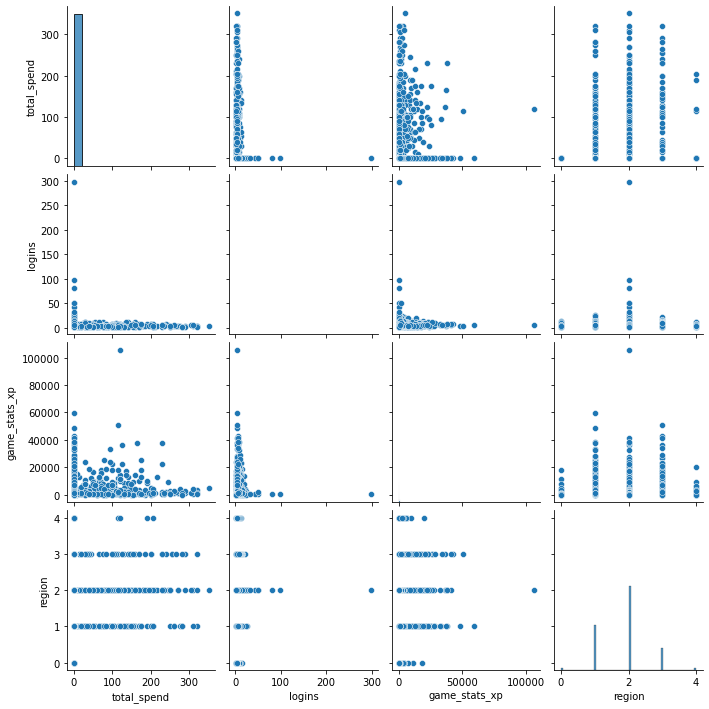

In [5]:
# plot the pair plot of some columns in data dataframe.
# Notes to observe from this pairplot: 
# Some columns like region is not balanced, we have lots of users from Asia 
sns.pairplot(data = df.sample(frac=0.01), vars=['total_spend','logins','game_stats_xp', 'region'])
plt.show()

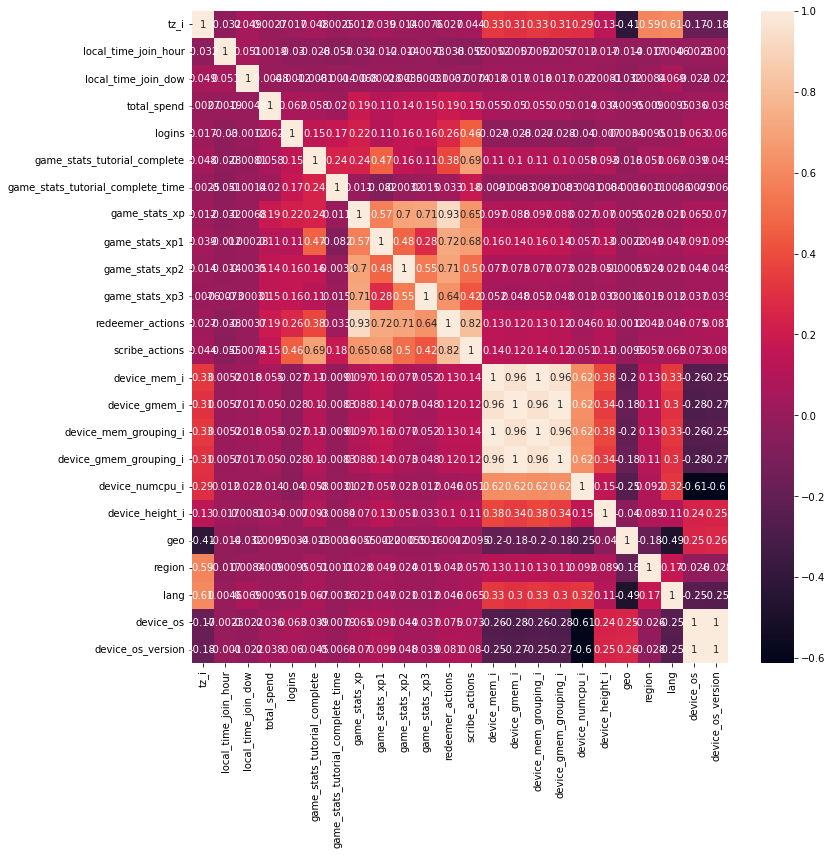

In [6]:
# To find what columns are correlated, lets create the 2D matrix of correlations
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.sample(frac=0.01).corr(), annot=True, ax=ax)
plt.show()

Correlated features in general don't improve models, and also it is always better to make the model simpler. Let's remove highly correlated features: 

In [7]:
feature_remove_list = [
    'device_gmem_i', 'device_mem_grouping_i', 'device_gmem_grouping_i', 
    'logins', 'redeemer_actions', 'game_stats_xp'
]
df = df.drop(columns = feature_remove_list)

## Step3: Preparing training/test sets

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

all_features = list(df.columns)

# Normalize all columns:
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df)

target = 'total_spend'
features = list(df.columns)
features.remove(target)

df, df_test = train_test_split(df, test_size=0.2, shuffle=True)


## Model1: RandomForest

Evaluate the training set


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   25.3s finished


Error: 0.00
F1 score: 0.33


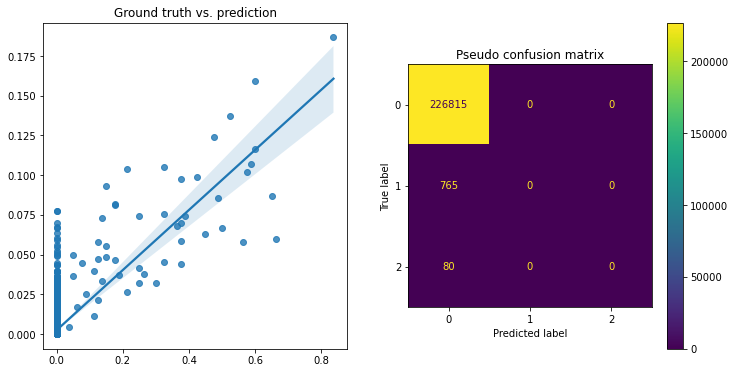

Evaluate the test set


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.2s finished


Error: 0.01
F1 score: 0.33


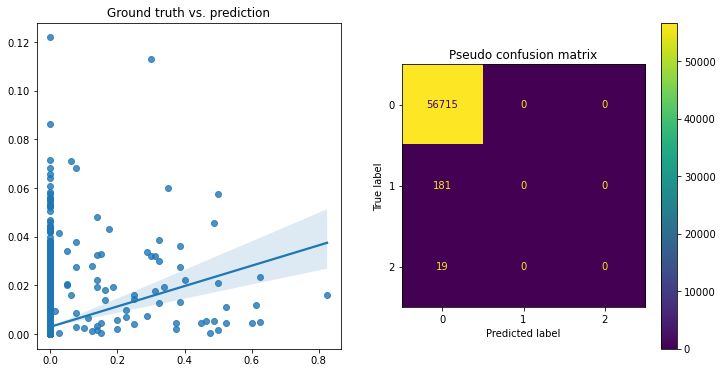

In [17]:
import os
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

model1_path = os.path.join('models', 'model_rf')

if os.path.exists(model1_path):
    model1 = pickle.load(open(model1_path, 'rb'))
else:
    model1 = RandomForestRegressor(max_depth=20, 
                                   n_estimators=1000,
                                   min_samples_split=10,
                                   min_samples_leaf=4,
                                   max_features='sqrt',
                                   bootstrap=True,
                                   verbose=True)

    model1.fit(df[features].values, df[target].values)
    with open(model1_path, 'wb') as f:
        pickle.dump(model1, f)

print('Evaluate the training set')
y_hat = model1.predict(df[features].values)
helper.model_eval.evaluate(df[target].values, y_hat, n_classes=3)
helper.model_eval.evaluate_plots(df[target].values, y_hat, n_classes=3)

print('Evaluate the test set')
y_hat = model1.predict(df_test[features].values)
helper.model_eval.evaluate(df_test[target].values, y_hat, n_classes=3)
helper.model_eval.evaluate_plots(df_test[target].values, y_hat, n_classes=3)

As you can see, the model is underfitted and highly biased towards 0 and is not able make predictions for values near 1.

## Model2: Neural Networks (simple regressor)

  0%|                                                                                       | 0/100 [00:00<?, ?it/s]C:\Users\amin_\Anaconda3\envs\kaban\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.50it/s]


epoch 99, loss 0.08201474149046291
Evaluate the training set
Error: 0.27
F1 score: 0.22


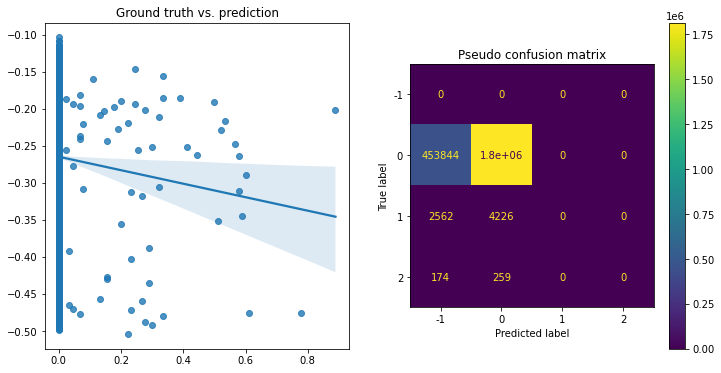

Evaluate the test set
Error: 0.27
F1 score: 0.22


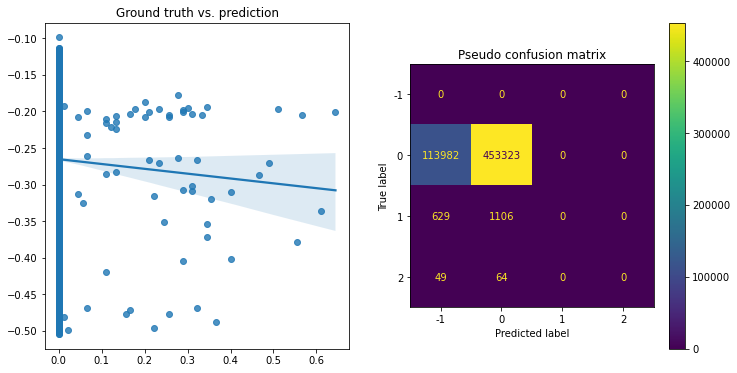

In [12]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
model_nn_path = os.path.join('models', 'model_simple_nn')

Xt, yt = df[features].values, df[target].values
Xt, yt = torch.from_numpy(Xt), torch.from_numpy(yt)


model = torch.nn.Sequential(
    torch.nn.Linear(Xt.shape[1], 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1)
).double()

if os.path.exists(model_nn_path):
    model.load_state_dict(torch.load(model_nn_path))
    model.eval()
else:        
    learning_rate = 0.0001
    l = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    

    num_epochs = 100
    for epoch in tqdm(range(num_epochs)):
        ind = np.random.choice(Xt.shape[0], 10000, replace=False)
        xt_ind, yt_ind = Xt[ind], yt[ind]
        y_pred = model(xt_ind.requires_grad_())
        loss= l(y_pred, yt_ind)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))    
    
    torch.save(model.state_dict(), model_nn_path)  


print('Evaluate the training set')
y_hat = model(Xt).detach().numpy().flatten()
helper.model_eval.evaluate(df[target].values, y_hat, n_classes=3)
helper.model_eval.evaluate_plots(df[target].values, y_hat, n_classes=3)

print('Evaluate the test set')
Xt, yt = df_test[features].values, df_test[target].values
Xt, yt = torch.from_numpy(Xt), torch.from_numpy(yt)

y_hat = model(Xt).detach().numpy().flatten()
helper.model_eval.evaluate(df_test[target].values, y_hat, n_classes=3)
helper.model_eval.evaluate_plots(df_test[target].values, y_hat, n_classes=3)